In [10]:
import xarray as xr
import numpy as np

# Load dataset
ds = xr.open_dataset(r"Data\Climate Data\4. Merged_Tas_Climate\Tas_Combined_Data.nc")

# Keep only 3D climate variables, ignore spatial_ref
vars_to_check = [v for v in ds.data_vars if ds[v].ndim == 3]


In [13]:
# -----------------------------------
# STEP 1: Build land mask
# -----------------------------------
valid_mask = None

for var in vars_to_check:
    arr = ds[var]                                 # (time, lat, lon)
    mask_var = ~arr.isnull().any(dim="time")      # True = land
    valid_mask = mask_var if valid_mask is None else (valid_mask & mask_var)

valid_mask_flat = valid_mask.values.reshape(-1)

print("Total grids:", valid_mask_flat.size)
print("Valid land grids:", valid_mask_flat.sum())
print("Removed:", (~valid_mask_flat).sum())

# -----------------------------------
# STEP 2: Create node-format variables
# -----------------------------------
T = ds.dims["time"]
clean_vars = {}

for var in vars_to_check:
    arr = ds[var].values.reshape(T, -1)
    arr = arr[:, valid_mask_flat]
    clean_vars[var] = (("time", "node"), arr)

# -----------------------------------
# STEP 3: Save lat/lon & mask
# -----------------------------------
lat_grid_2d = np.repeat(ds.lat.values[:, None], ds.lon.size, axis=1)
lon_grid_2d = np.repeat(ds.lon.values[None, :], ds.lat.size, axis=0)

lat_flat = lat_grid_2d.reshape(-1)
lon_flat = lon_grid_2d.reshape(-1)

clean_vars["lat"] = (("node",), lat_flat[valid_mask_flat])
clean_vars["lon"] = (("node",), lon_flat[valid_mask_flat])

clean_vars["valid_mask_flat"] = (("grid",), valid_mask_flat)
clean_vars["lat_grid"] = (("lat","lon"), lat_grid_2d)
clean_vars["lon_grid"] = (("lat","lon"), lon_grid_2d)

# -----------------------------------
# STEP 4: Save as node-format NetCDF
# -----------------------------------
clean_ds = xr.Dataset(
    clean_vars,
    coords={"time": ds.time, "node": np.arange(valid_mask_flat.sum())}
)

clean_ds.to_netcdf(r"Data\Climate Data\4. Merged_Tas_Climate\tasmania_clean_node.nc")

print("✔ Saved as tasmania_clean_node.nc")

Total grids: 7728
Valid land grids: 2951
Removed: 4777
✔ Saved as tasmania_clean_node.nc


C:\Users\u1171032\AppData\Local\Temp\ipykernel_4196\3768152815.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  T = ds.dims["time"]


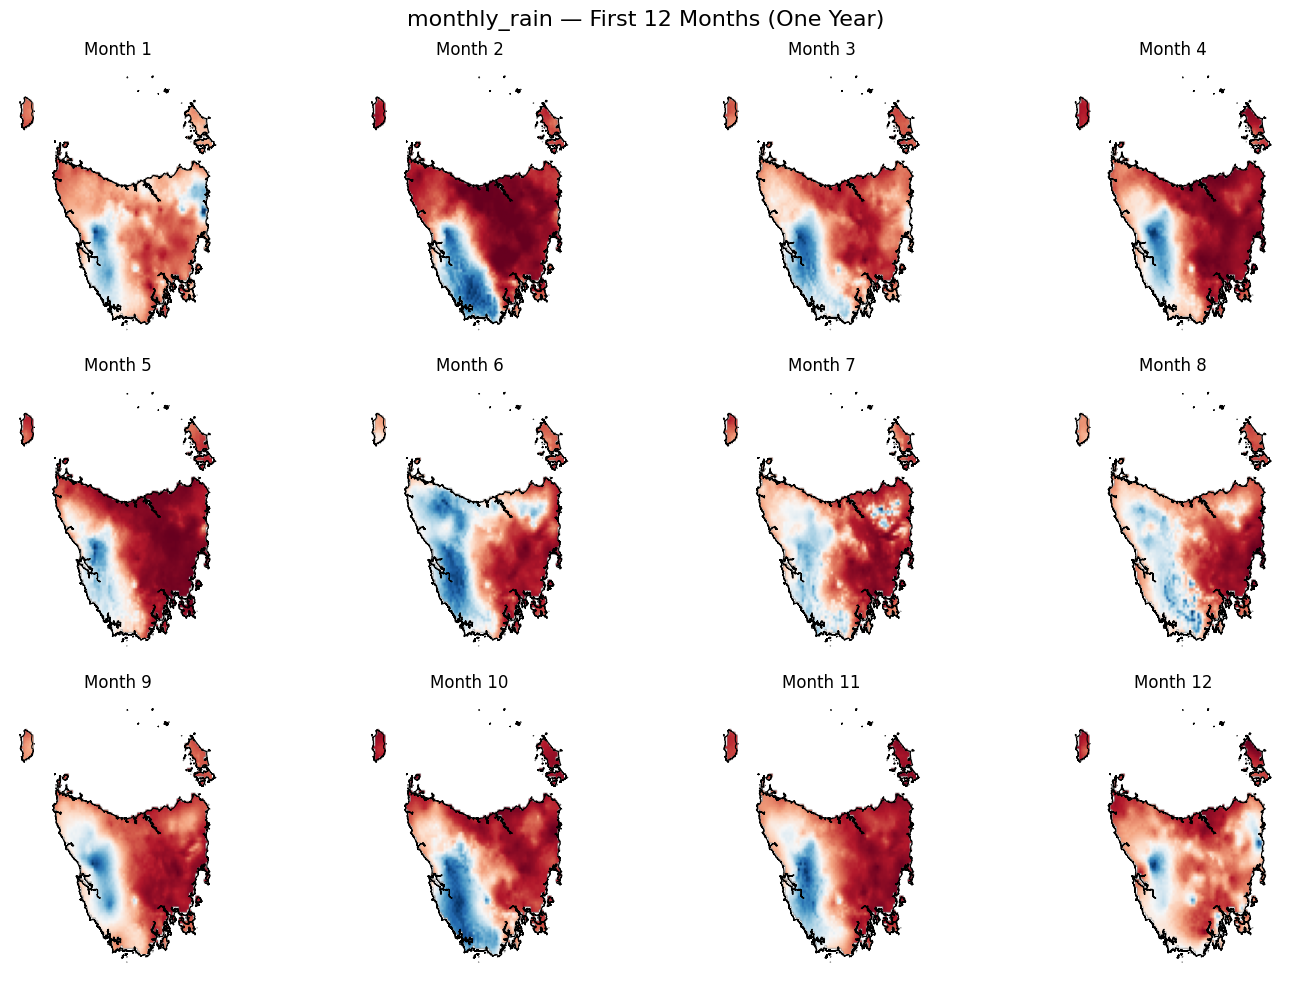

In [25]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -------------------------
# Load cleaned node dataset
# -------------------------
ds = xr.open_dataset(r"Data\Climate Data\4. Merged_Tas_Climate\tasmania_clean_node.nc")

# === Load the shapefile (Tasmania boundary) ===
shapefile_path = r'Data\Tas_Shapefile\tasmania.shp'
tas_shape = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

# Choose a variable to plot
varname = "monthly_rain"   # ← change if needed

# Get needed components
values = ds[varname].values            # shape: (time, node)
mask = ds["valid_mask_flat"].values    # shape: (lat*lon,)
lat_grid = ds["lat_grid"].values       # (84, 92)
lon_grid = ds["lon_grid"].values       # (84, 92)

# Flatten lat/lon for plotting boundaries
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# -------------------------
# Plot 12 months (1 year)
# -------------------------
plt.figure(figsize=(15, 10))

for month in range(12):  # months 0–11

    # Create empty map
    full_map = np.full(mask.shape, np.nan)

    # Fill land pixels only
    full_map[mask] = values[month]

    # Reshape to (lat, lon)
    full_map = full_map.reshape(lat_grid.shape)

    # Create subplot axis first
    ax = plt.subplot(3, 4, month + 1)

    # Plot raster
    im = ax.imshow(
        full_map,
        origin="lower",
        cmap="RdBu",
        extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
    )

    # Overlay shapefile boundaries
    tas_shape.boundary.plot(ax=ax, color='black', linewidth=0.8)

    ax.set_title(f"Month {month+1}")
    ax.axis("off")

plt.suptitle(f"{varname} — First 12 Months (One Year)", fontsize=16)
plt.tight_layout()
plt.show()
